In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from allen_v1dd.client import OPhysClient
from v1dd_public import ARTIFACT_DIR
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap
import os

np.random.seed(42)

In [2]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [3]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
H5_DIR = os.path.join(ARTIFACT_DIR, 'stimulus_analyses_v2.h5')
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
client =  OPhysClient(DATA_DIR)

In [4]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [5]:
res2 = ['frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm'
       ]
features = cell_info[res2]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'})

In [10]:
ax.get_yticks()

array([0.5, 1.5, 2.5, 3.5, 4.5])

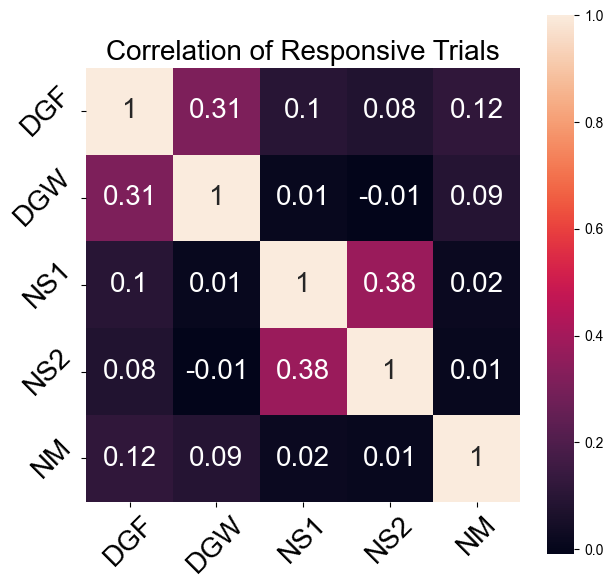

In [17]:
corrMatrix = features.corr()        # compute the correlation matrix (default is Pearson)
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
sns.heatmap(np.round(corrMatrix,2), annot_kws={"size": fontsize}, annot=True, ax=ax)
ax.set_title('Correlation of Responsive Trials', fontsize=fontsize)
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['DGF', 'DGW', 'NS1', 'NS2', 'NM'])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['DGF', 'DGW', 'NS1', 'NS2', 'NM'])
ax.tick_params(which='major', axis='both', labelsize=fontsize, rotation=45)
ax.set_aspect('equal')

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5A_correlation_of_responsive_trials.svg'), dpi=300)

If for any reason the numbers are not shown in the correlation matrix run: pip install --upgrade seaborn matplotlib!

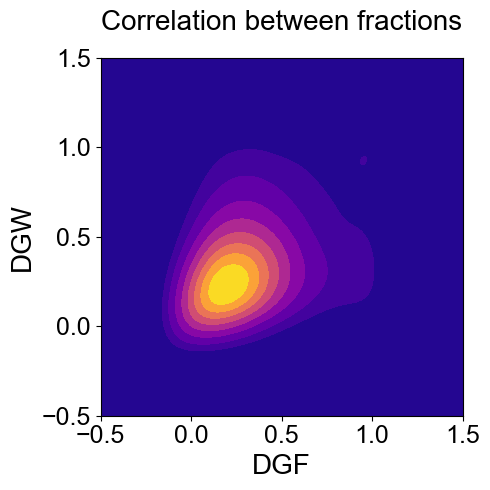

In [18]:
feature1 = 'DGF'
feature2 = 'DGW'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xlabel("DGF", fontsize=font)
plt.ylabel("DGW", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title("Correlation between fractions", fontsize=font, pad=20)
plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5B_correlation_DGF_DGW.svg'), dpi=300)

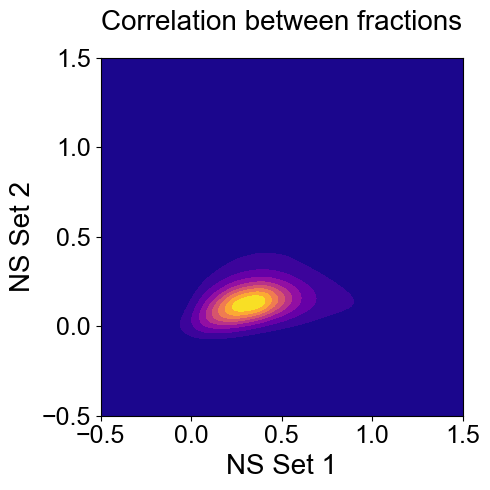

In [19]:
feature1 = 'NI118'
feature2 = 'NI12'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xlabel("NS Set 1", fontsize=font)
plt.ylabel("NS Set 2", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title(f"Correlation between fractions", fontsize=font, pad=20)
plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5B_correlation_NS1NS2.svg'), dpi=300)

### Define the stmulus pairs from csv columns for performing correlation analysis

In [42]:
res3 = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z'
       ]
features = cell_info[res3]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z':'depth'})

In [43]:
pairs = [['DGW', 'DGF'], ['DGW', 'NI12'], ['DGW', 'NI118'], ['NI12', 'NI118']]
n_pairs = len(pairs)
n_bootstrap = 1000
boot_size = 30
depths = features.depth.unique()
depths = [depth for depth in depths if depth != 500 and depth <= 514]
depths = np.array(depths)
depths.sort()
n_depths = len(depths)
mice = features.mouse_id.unique()
n_mice = len(mice)
rng = np.random.default_rng()
# bootstrapped_data = np.zeros((n_pairs, n_mice, n_depths, n_bootstrap))
bootstrapped_data = np.empty(n_bootstrap, dtype=float)
results = {
    'mouse_id': [],
    'depth': [],
    'feature1': [],
    'feature2': [],
    'bootstrap_correlations': []
}

for m, mouse_id in enumerate(mice):
    for z, depth in enumerate(depths):
        data = features[(features.mouse_id == mouse_id) & (features.depth == depth)]
        for p, (feature1, feature2) in enumerate(pairs):
            data1 = data[feature1].values
            data2 = data[feature2].values
            n1 = len(data1)
            n2 = len(data2)
            if n1 > boot_size and n2 > boot_size:
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(data1)), size=boot_size, replace=True)
                    sampled1 = data1[sample_indices]
                    sampled2 = data2[sample_indices]
                    bootstrapped_data[b] = np.corrcoef(sampled1, sampled2)[0, 1]
            else:
                bootstrapped_data[:] = np.nan

            results['mouse_id'].append(mouse_id)
            results['depth'].append(depth)
            results['feature1'].append(feature1)
            results['feature2'].append(feature2)
            results['bootstrap_correlations'].append(bootstrapped_data.copy())

corr_results_df = pd.DataFrame(
    data=[
        np.repeat(np.array(results['mouse_id']), n_bootstrap),
        np.repeat(np.array(results['depth']), n_bootstrap),
        np.repeat(np.array(results['feature1']), n_bootstrap),
        np.repeat(np.array(results['feature2']), n_bootstrap),
        np.concatenate(results['bootstrap_correlations'])
    ]
).T

corr_results_df = corr_results_df.rename(columns={
    0: 'mouse_id',
    1: 'depth',
    2: 'feature1',
    3: 'feature2',
    4: 'bootstrap_correlation'
})

/tmp/ipykernel_900140/835187268.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))
/tmp/ipykernel_900140/835187268.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))
/tmp/ipykernel_900140/835187268.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

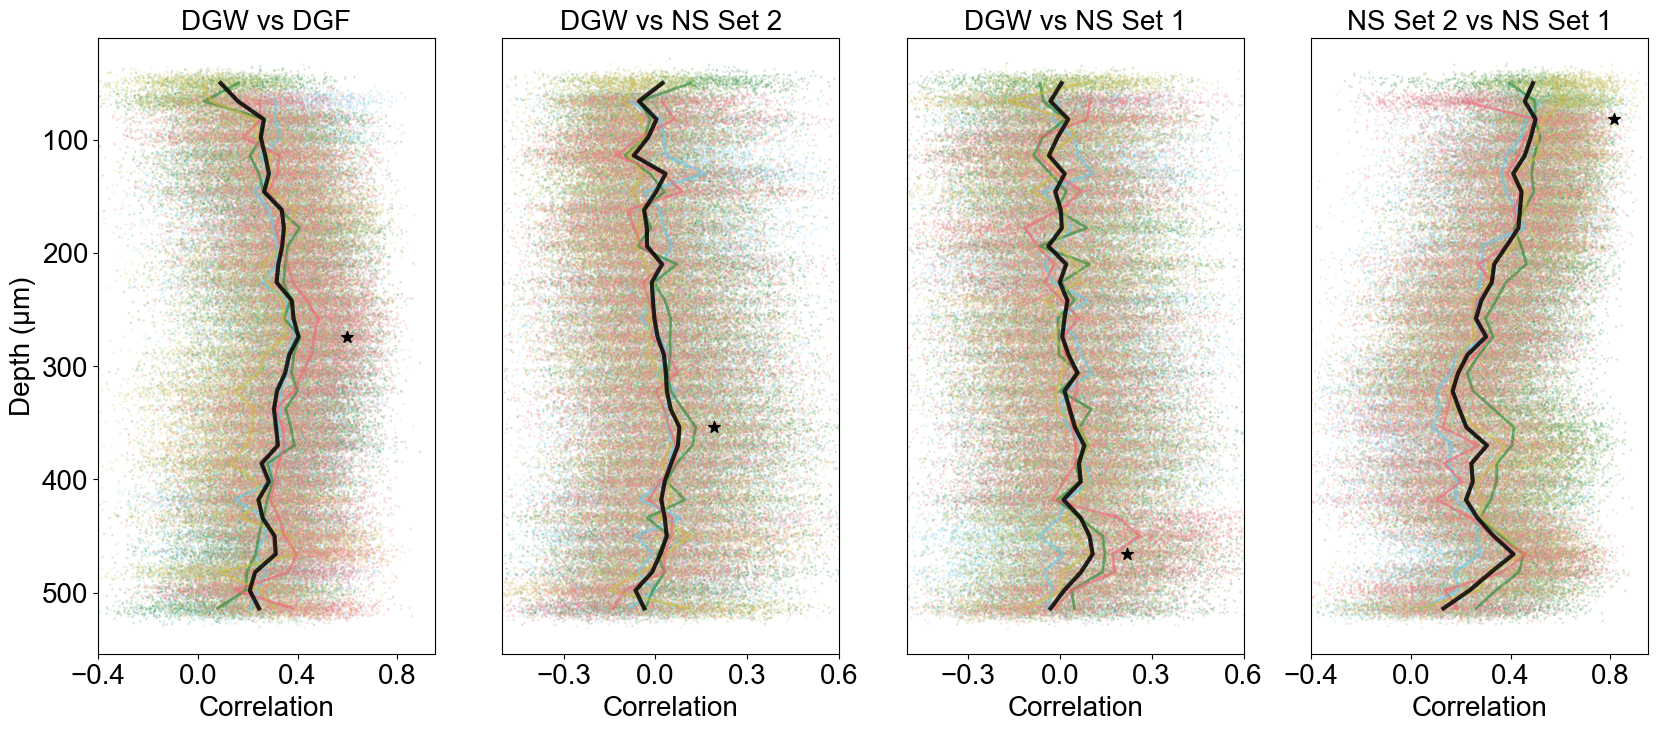

In [35]:
#### Plotting decoding accuracies for each mouse
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

# Some parameters for the plot
z_values = corr_results_df['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
stim_to_title = {
    'DGF': 'DGF',
    'DGW': 'DGW',
    'NI118': 'NS Set 1',
    'NI12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for idx, (feature1, feature2) in enumerate(pairs):
    ax = axs[idx]

    temp_df = corr_results_df[(corr_results_df['feature1'] == feature1) & (corr_results_df['feature2'] == feature2)]

    sns.lineplot(
        data=temp_df,
        x='bootstrap_correlation',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False #if idx != 3 else True,
    )

    # ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='bootstrap_correlation', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['bootstrap_correlation'].mean().reset_index()
    sub_array = sub_df['bootstrap_correlation'].values
    sub_array = sub_array[~np.isnan(sub_array)]
    axs[idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='bootstrap_correlation',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        s=3,
        alpha=0.2,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_title(f'{stim_to_title[feature1]} vs {stim_to_title[feature2]}', fontsize=fontsize)
    ax.set_xlabel('Correlation', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    ax.set_xlim(left=-0.4, right=0.95) if idx == 0 or idx == 3 else ax.set_xlim(left=-0.5, right=0.6)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG5C_corr_resp_frac_depth.png'), dpi=300)

### Run regression to see if the decoding accuracy is dep. on corr. btwn resp fractions

In [36]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

In [37]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

In [41]:
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
decoding_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    temp_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        temp_df = pd.concat([temp_df, pd.read_pickle(f)])
    
    temp_df['stim_type_training'] = stim_type
    temp_df['stim_type_testing'] = other_stim_type
    temp_df['decode_dim'] = decode_dim

    decoding_results_df = pd.concat([decoding_results_df, temp_df], axis=0)

decoding_results_df['depth'] = decoding_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

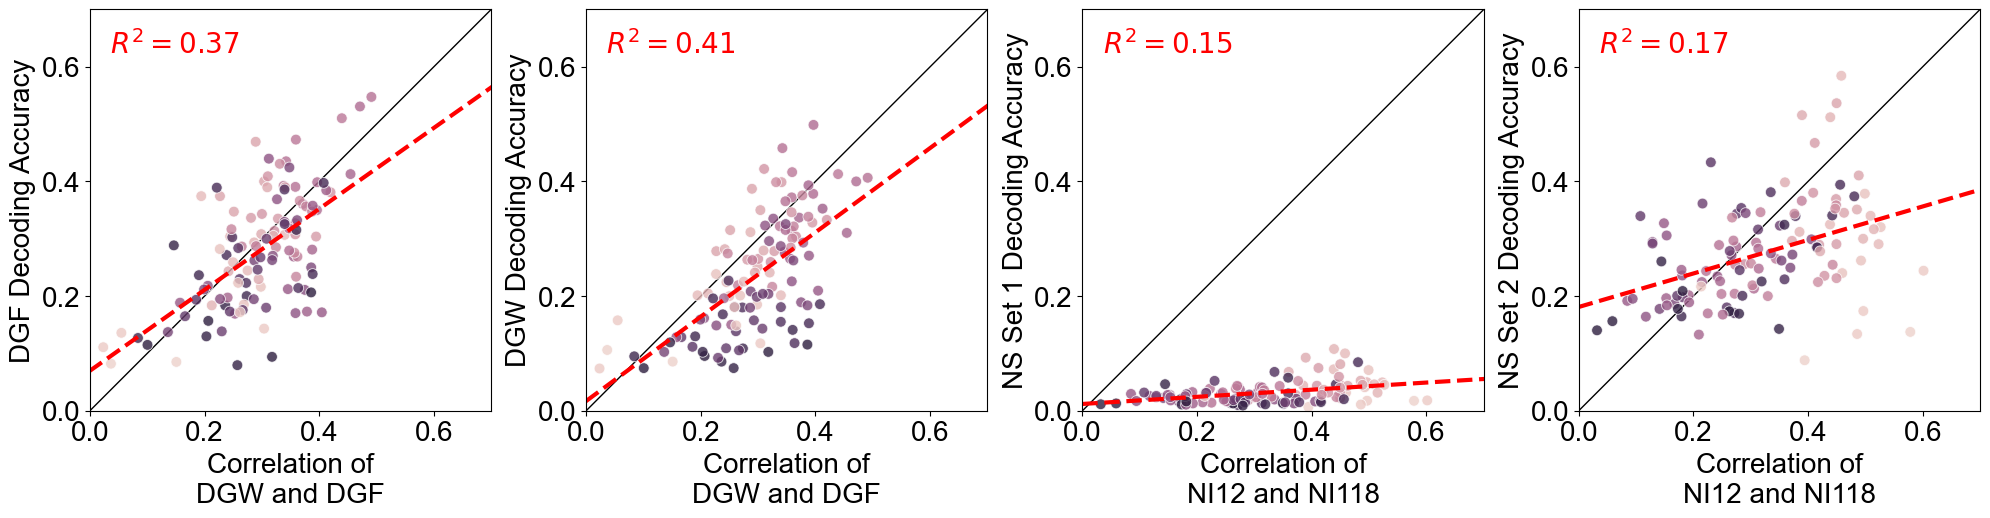

In [97]:
from sklearn.linear_model import LinearRegression
pairs_to_plot = [['DGW', 'DGF'], ['NI12', 'NI118']]
pairs_to_stims = {
    'DGW': ['drifting_gratings_full', 'drifting_gratings_windowed'],
    'NI12': ['natural_images', 'natural_images_12']
}
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
mouse_mapping = {
    409828: 'slc2',
    416296: 'slc4',
    427836: 'slc5',
    438833: 'teto1'
}

corr_results_mean_df = corr_results_df.groupby(by=['mouse_id', 'depth', 'feature1', 'feature2'])['bootstrap_correlation'].mean().reset_index()
decoding_results_mean_df = decoding_results_df.explode('val_accuracy').groupby(by=['mouse_id', 'depth', 'stim_type_training'])['val_accuracy'].mean().reset_index()
mouse_mapping = {
    409828: 'slc2',
    416296: 'slc4',
    427836: 'slc5',
    438833: 'teto1'
}
decoding_results_mean_df['mouse_id'] = decoding_results_mean_df['mouse_id'].map(mouse_mapping)
decoding_results_mean_df = decoding_results_mean_df[(decoding_results_mean_df['depth'] <= 514) & (decoding_results_mean_df['depth'] != 500)]

fig, axs = plt.subplots(1, 4, figsize=(20, 8))
count = 0
for (feature1, feature2) in pairs_to_plot: 
    for stim in pairs_to_stims[feature1]:
        ax = axs[count]

        sub_df = corr_results_mean_df[(corr_results_mean_df['feature1'] == feature1) & (corr_results_mean_df['feature2'] == feature2)]
        other_sub_df = decoding_results_mean_df[decoding_results_mean_df['stim_type_training'] == stim]
        merge_df = sub_df.merge(other_sub_df, on=['mouse_id', 'depth'])
        depth_values = merge_df['depth'].unique()
        depth_values.sort()

        sns.scatterplot(
            data=merge_df,
            x='bootstrap_correlation',
            y='val_accuracy',
            hue='depth',
            ax=ax,
            s=60, 
            alpha=0.8,
            legend=False
        )

        sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=depth_values.min(), vmax=depth_values.max()))
        sm.set_array([])
        ax.figure.colorbar(sm, ax=ax) if idx == 3 else None

        ax.set_xlim(0, 0.7)
        ax.set_ylim(0, 0.7)
        # ax.set_xticks([0.25, 0.5, 0.75])
        # ax.set_yticks([0.25, 0.5, 0.75])

        # Fit a linear regression model
        x_data = merge_df['bootstrap_correlation'].values
        y_data = merge_df['val_accuracy'].values
        y_data = y_data[~np.isnan(x_data)]
        x_data = x_data[~np.isnan(x_data)]
        model = LinearRegression()
        model.fit(x_data.reshape(-1, 1), y_data)
        
        # Plot the regression line
        x_fit = np.linspace(-1, 1, 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))
        ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression')

        # Add text annotation for R^2 value
        r_squared = model.score(x_data.reshape(-1, 1), y_data)
        ax.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', 
                transform=ax.transAxes, fontsize=20, verticalalignment='top', color='red')
        
        ax.plot([-1, 1], [-1, 1], color='black', linestyle='-', linewidth=1, zorder=0)   

        ax.set_xlabel(f'Correlation of\n{feature1} and {feature2}', fontsize=20)
        ax.set_ylabel(f'{titles[stim]} Decoding Accuracy', fontsize=20)
        ax.tick_params(axis="both", which="major", labelsize=20)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.set_aspect('equal', adjustable='box')

        count += 1

plt.suptitle('')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG5D_corr_vs_decoding_accuracy.png'), dpi=300)


### Run stats on depth-dependent trends

In [98]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

In [99]:
corr_results_df

,mouse_id,depth,feature1,feature2,bootstrap_correlation
0,slc2,50,DGW,DGF,NaN
1,slc2,50,DGW,DGF,NaN
2,slc2,50,DGW,DGF,NaN
3,slc2,50,DGW,DGF,NaN
4,slc2,50,DGW,DGF,NaN
...,...,...,...,...,...
479995,teto1,514,NI12,NI118,0.215156
479996,teto1,514,NI12,NI118,0.279776
479997,teto1,514,NI12,NI118,-0.044023
479998,teto1,514,NI12,NI118,0.338046


In [ ]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests


# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
pairs = [['DGW', 'DGF'], ['DGW', 'NI12'], ['DGW', 'NI118'], ['NI12', 'NI118']]

# fig, axs = plt.subplots(1, len(stim_types), figsize=(25, 5))
for idx, (feature1, feature2) in enumerate(pairs):
    sub_df = corr_results_df[(corr_results_df['depth'] <= 514) & (corr_results_df['depth'] != 500)]
    mean_acc_df = sub_df.explode('val_accuracy').groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth', 'stim_type_training'])['val_accuracy'].mean()
    mean_acc_df = mean_acc_df.reset_index()
    mean_acc_DGF_df = mean_acc_df[mean_acc_df['stim_type_training'] == stim_type].drop(columns=['stim_type_training'])

    df = mean_acc_DGF_df.copy()
    df = df.sort_values(by='depth').reset_index()
    df['mouse_id'] = df['mouse_id'].astype("category")
    df['column_id'] = df['column_id'].astype("category")
    df['depth'] = df['depth'].astype("category")
    depth_levels = df.depth.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        "val_accuracy ~ C(depth)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(depth)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)


    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[stim_type]} - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("depth")["val_accuracy"].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG_sigtestsforfig5c_{titles[stim_type]}.png"), format="png", dpi=300)
